# 2. 채용 데이터 시각화

- 크롤링 데이터 업로드
- keyword 추출, WordCloud 시각화
- seaborn 라이브러리를 이용한 barplot
- 신입 / 경력 빈도 분석
- Folium을 이용해 채용공고 지역 표시
자치구별 채용공고 빈도 barplot, pie chart

## 2-1 크롤링 데이터 업로드

In [5]:
import pandas as pd
import warnings
warnings.filterwarnings(action='ignore')

df = pd.read_csv("jumpit_crawling_데이터 엔지니어_2024-02-19.csv", index_col='Unnamed: 0')
df.head(1)

,company,title,url,city,district,remain_address,career,education_date,stack,main_task,qualification,more,duetime,years_of_experience,established_date,total_employees,company_type,view
0,워트인텔리전스,[워트 개발팀] 데이터 엔지니어 모집 (국내 최대 데이터),https://www.jumpit.co.kr/position/7326,서울시,서초구,"강남대로 507, 6층",경력 2~10년,대학교졸업(4년) 이상,"MongoDB, BigData, REST API, Hadoop, Java, Luce...","다양한 서비스를 제공하기 위해 Airflow를 활용한 데이터 파이프라인 구축, 데이...","• Java, Python, SQL 을 다루는데 어려움이 없으신 분\n• Linux...","• 검색서비스 개발과 자연어 처리 경험 보유자 우대\n• 머신러닝, 딥러닝 기반 업...",상시,10.0,2015-5-27,40.0,"중소기업, 주식회사, 사단법인",370


In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 274 entries, 0 to 273
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   company              274 non-null    object 
 1   title                274 non-null    object 
 2   url                  274 non-null    object 
 3   city                 274 non-null    object 
 4   district             274 non-null    object 
 5   remain_address       274 non-null    object 
 6   career               274 non-null    object 
 7   education_date       274 non-null    object 
 8   stack                274 non-null    object 
 9   main_task            274 non-null    object 
 10  qualification        274 non-null    object 
 11  more                 274 non-null    object 
 12  duetime              274 non-null    object 
 13  years_of_experience  238 non-null    float64
 14  established_date     251 non-null    object 
 15  total_employees      211 non-null    float64


## 2-2 keyword 추출, WordCloud 시각화


- stack 열에서 영어만 추출해 모두 소문자로 변환

- 불용어 설정 후 키워드 추출
  
- WordCloud를 사용해 키워드 빈도 시각화


## 2-3 seaborn 라이브러리를 이용한 barplot


- 영어만 추출, 소문자 변환, 불용어 처리된 데이터로 단어 빈도수 계산

- 빈도수 상위 10개 단어 추출 후 Seaborn 이용해 barplot


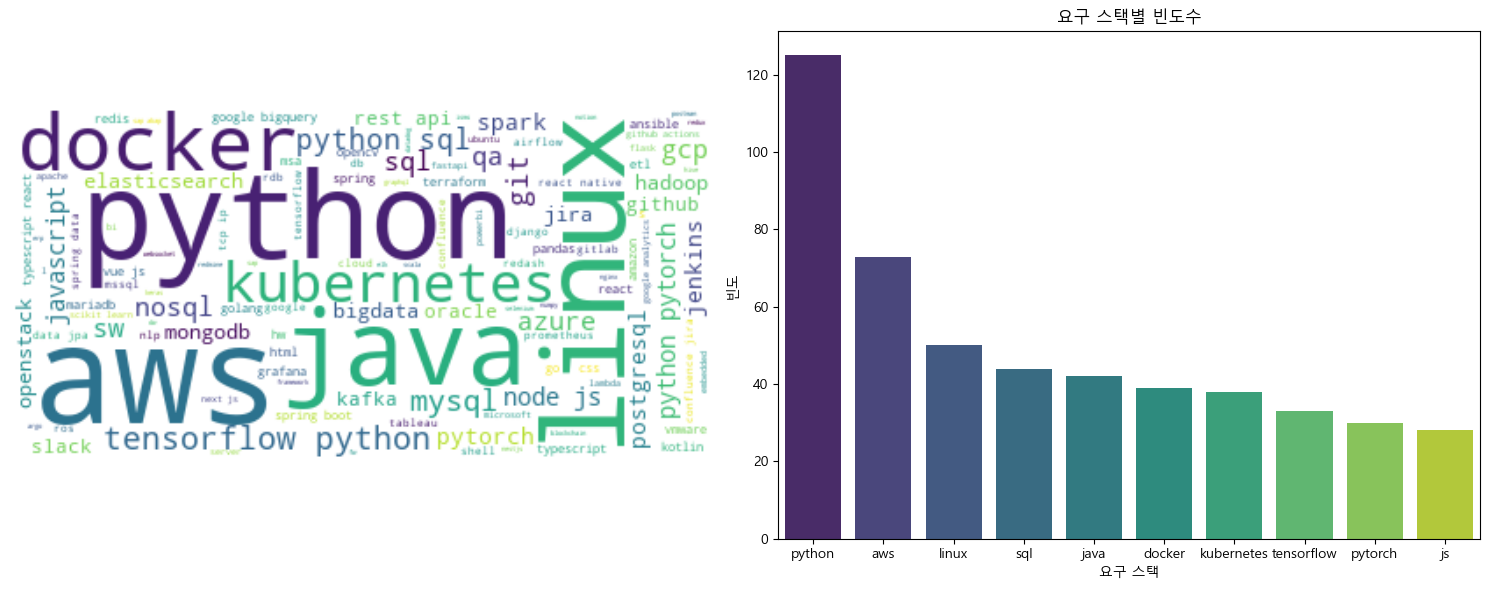

In [9]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
import re
from collections import Counter
import seaborn as sns

#한글 깨짐
plt.rcParams['font.family'] = 'Malgun Gothic'

# 데이터프레임에서 워드클라우드를 생성할 열 선택 (예: '제목')
text = ' '.join(df['stack'])

# 영어만 추출하고 모두 소문자로 변환
text_eng_only = ' '.join(re.findall('[a-zA-Z]+', text)).lower()

# 불용어 추가
custom_stopwords = set(STOPWORDS)
custom_stopwords.update(['deeplearning', 'machinelearning', 'network','windows', 'ai', 'c'])

## 워드클라우드 객체 생성, 불용어 매개변수에 custom_stopwords 사용
wordcloud = WordCloud( 
                      stopwords=custom_stopwords,
                      background_color='white').generate(text_eng_only)

# 워드클라우드 시각화
plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 1)  # 1행 2열 중 첫 번째
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')

# text_eng_only에서 불용어 제외
words = [word for word in text_eng_only.split() if word not in custom_stopwords]

# 단어의 빈도수 계산
word_counts = Counter(words)

# 빈도수가 가장 높은 상위 N개의 단어 선택 (예: 상위 10개)
top_n = 10
top_words = word_counts.most_common(top_n)

# 데이터프레임 생성
df_words = pd.DataFrame(top_words, columns=['Word', 'Frequency'])

# 데이터프레임 열 이름 변경
df_words.rename(columns={'Word': '요구 스택', 'Frequency': '빈도'}, inplace=True)

# seaborn으로 바 그래프 시각화
plt.subplot(1, 2, 2)  # 1행 2열 중 두 번째
sns.barplot(y='빈도', x='요구 스택', data=df_words, palette='viridis')  # palette 변경 가능
plt.title('요구 스택별 빈도수')
plt.ylabel('빈도')
plt.xlabel('요구 스택')

plt.tight_layout()  # 그래프 간격 조정
plt.show()

## 2-4 신입 / 경력 빈도 분석


- ### 신입과 경력 n년을  int값으로 반환
  - 문자열에 신입이란 문자가 있으면 0 반환 
  - 그 외에는 최소 요구 경력 값 반환

In [7]:
careers = df['career']

# 최소 요구 경력만 추출하는 함수
def extract_min_career(career_str):
    # '신입'이라는 문자열이 있는지 확인
    if '신입' in career_str:
        return 0
    else:
        # 숫자를 추출하여 리스트로 저장
        years = re.findall(r'\d+', career_str)
        # 최소 요구 경력을 구함
        min_career = min(map(int, years))
        return min_career

# 각 항목의 최소 요구 경력 추출
min_careers = [extract_min_career(career) for career in careers]

print(min_careers)

[2, 3, 0, 3, 3, 2, 0, 2, 7, 0, 3, 10, 3, 1, 3, 5, 4, 1, 5, 0, 2, 5, 2, 3, 0, 3, 10, 6, 3, 3, 3, 3, 1, 5, 4, 3, 2, 2, 0, 2, 2, 2, 5, 0, 7, 8, 5, 5, 3, 5, 2, 2, 5, 10, 3, 6, 3, 3, 3, 7, 5, 1, 2, 3, 5, 1, 3, 5, 0, 5, 1, 6, 3, 8, 4, 3, 4, 5, 4, 3, 5, 5, 3, 5, 0, 8, 3, 1, 3, 3, 1, 1, 5, 3, 0, 3, 1, 2, 4, 1, 0, 0, 5, 3, 2, 0, 5, 0, 0, 2, 0, 0, 3, 2, 3, 1, 4, 3, 4, 1, 3, 7, 2, 3, 8, 3, 3, 7, 0, 0, 3, 3, 4, 3, 4, 4, 3, 0, 3, 3, 4, 3, 0, 2, 5, 0, 6, 5, 3, 2, 3, 1, 2, 4, 3, 5, 0, 2, 1, 5, 1, 5, 1, 1, 2, 3, 3, 3, 1, 3, 3, 3, 3, 5, 5, 1, 2, 1, 3, 1, 2, 3, 5, 5, 2, 0, 2, 0, 2, 0, 5, 0, 5, 5, 3, 3, 6, 3, 1, 3, 0, 2, 2, 5, 5, 0, 4, 1, 5, 2, 3, 3, 5, 0, 3, 0, 3, 3, 2, 3, 2, 3, 2, 0, 3, 2, 0, 2, 1, 3, 6, 3, 2, 3, 3, 2, 5, 10, 5, 3, 3, 1, 0, 3, 0, 3, 5, 5, 3, 3, 5, 1, 5, 5, 3, 5, 3, 0, 7, 4, 1, 3, 3, 3, 3, 3, 0, 3, 2, 3, 5, 4, 4, 10]


- ### int값을 범주화
  - 3년, 5년, 7년 기준으로 분류
  - 신입, 경력 1 ~ 2년, 경력 3 ~ 5년, 경력 5 ~ 7년, 경력 7년 이상으로 범주화

In [8]:
# 각 정수 값을 범주로 변환하는 함수
def categorize_career(years):
    if years == 0:
        return '신입'
    elif 1 <= years < 3:
        return '경력 1-2년'
    elif 3 <= years < 5:
        return '경력 3-5년'
    elif 5 <= years < 7:
        return '경력 5-7년'
    else:
        return '경력 7년 이상'

# 범주화된 최소 요구 경력 추출
categorized_careers = [categorize_career(year) for year in min_careers]

print(categorized_careers)

['경력 1-2년', '경력 3-5년', '신입', '경력 3-5년', '경력 3-5년', '경력 1-2년', '신입', '경력 1-2년', '경력 7년 이상', '신입', '경력 3-5년', '경력 7년 이상', '경력 3-5년', '경력 1-2년', '경력 3-5년', '경력 5-7년', '경력 3-5년', '경력 1-2년', '경력 5-7년', '신입', '경력 1-2년', '경력 5-7년', '경력 1-2년', '경력 3-5년', '신입', '경력 3-5년', '경력 7년 이상', '경력 5-7년', '경력 3-5년', '경력 3-5년', '경력 3-5년', '경력 3-5년', '경력 1-2년', '경력 5-7년', '경력 3-5년', '경력 3-5년', '경력 1-2년', '경력 1-2년', '신입', '경력 1-2년', '경력 1-2년', '경력 1-2년', '경력 5-7년', '신입', '경력 7년 이상', '경력 7년 이상', '경력 5-7년', '경력 5-7년', '경력 3-5년', '경력 5-7년', '경력 1-2년', '경력 1-2년', '경력 5-7년', '경력 7년 이상', '경력 3-5년', '경력 5-7년', '경력 3-5년', '경력 3-5년', '경력 3-5년', '경력 7년 이상', '경력 5-7년', '경력 1-2년', '경력 1-2년', '경력 3-5년', '경력 5-7년', '경력 1-2년', '경력 3-5년', '경력 5-7년', '신입', '경력 5-7년', '경력 1-2년', '경력 5-7년', '경력 3-5년', '경력 7년 이상', '경력 3-5년', '경력 3-5년', '경력 3-5년', '경력 5-7년', '경력 3-5년', '경력 3-5년', '경력 5-7년', '경력 5-7년', '경력 3-5년', '경력 5-7년', '신입', '경력 7년 이상', '경력 3-5년', '경력 1-2년', '경력 3-5년', '경력 3-5년', '경력 1-2년', '경력 1-2년', '경력 5-7년', '경력 3-5년', '

- ## seaborn 라이브러리 이용한 barplot

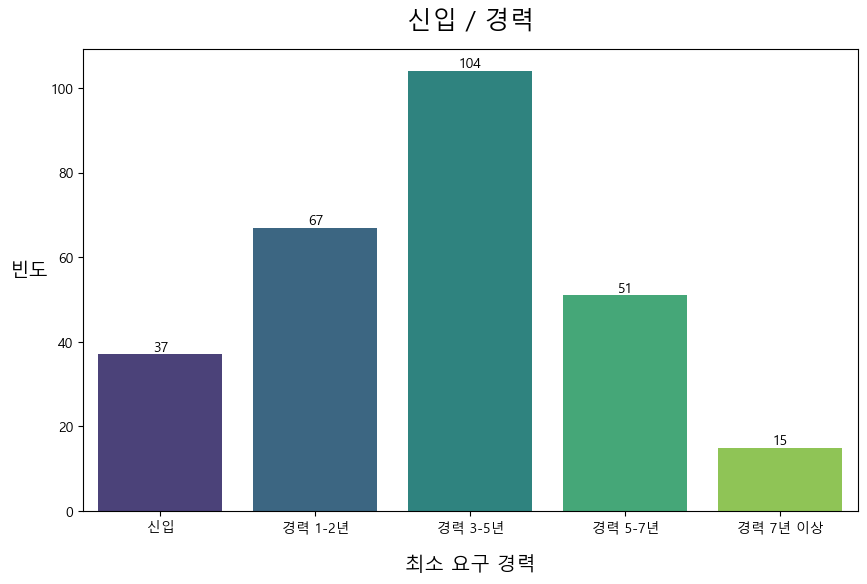

In [9]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 한글깨짐 오류 해결
plt.rcParams['font.family'] = 'Malgun Gothic'

# 데이터프레임 생성
df2 = pd.DataFrame({'Categorized Career': categorized_careers})

# 각 범주의 빈도수 계산
career_counts = df2['Categorized Career'].value_counts().reset_index()
career_counts.columns = ['Categorized Career', 'Frequency']

# 시각화를 위한 준비
plt.figure(figsize=(10, 6))
ax = sns.barplot(data=career_counts, x='Categorized Career', y='Frequency', palette='viridis',
                 order=['신입', '경력 1-2년', '경력 3-5년', '경력 5-7년', '경력 7년 이상'])

plt.title('신입 / 경력', fontsize=18, pad=15)
plt.xlabel('최소 요구 경력', fontsize=14, labelpad=15)
plt.ylabel('빈도', fontsize=14, rotation=0, labelpad=15)

# 막대 위에 카운트 값 표시
for p in ax.patches:
    ax.annotate(f'{p.get_height():.0f}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', 
                fontsize=10, color='black', 
                xytext=(0, 5), 
                textcoords='offset points')

plt.show()


## 2-5 지도 시각화 Folium


In [14]:
df3 = df[['company', 'district']]

df3.head(10)

,company,district
0,워트인텔리전스,서초구
1,핀다,강남구
2,무브멘토,성동구
3,웅진,중구
4,비포플레이,강남구
5,롯데헬스케어,송파구
6,마크클라우드,강남구
7,딥노이드,구로구
8,스윗코리아,강남구
9,애자일소다,강남구


### Geopy를 이용한 위도 경도값 추출
    - district 열의 구를 이용해 해당 위, 경도 값 추출
    - 기존 데이터 프레임에 위, 경도 열 추가

In [17]:
from geopy.geocoders import Nominatim
import pandas as pd
import time

# 지오코더 초기화
geolocator = Nominatim(user_agent="geoapiExercises")

# 위도와 경도를 저장할 리스트
latitudes = []
longitudes = []

# 각 주소에 대해 위도와 경도를 조회
for address in df3['district']:
    location = geolocator.geocode(address)
    if location:
        latitudes.append(location.latitude)
        longitudes.append(location.longitude)
    else:
        latitudes.append(None)
        longitudes.append(None)
    time.sleep(1)  # 요청 사이에 딜레이 추가

# 위도와 경도 정보를 df3에 추가
df3['latitude'] = latitudes
df3['longitude'] = longitudes

df3

,company,district,latitude,longitude
0,워트인텔리전스,서초구,37.483500,127.032200
1,핀다,강남구,37.517700,127.047300
2,무브멘토,성동구,37.563500,127.036500
3,웅진,중구,37.563656,126.997510
4,비포플레이,강남구,37.517700,127.047300
...,...,...,...,...
269,업스테이지,용인시,37.240574,127.178557
270,오엔제이,강남구,37.517700,127.047300
271,안티그래비티,성동구,37.563500,127.036500
272,안티그래비티,성동구,37.563500,127.036500


In [12]:
#df2.to_csv('place_district.csv', index=False, encoding='utf-8-sig')

### Folium을 이용해 채용공고 지역 표시
    - 가져온 위, 경도 값을 지도에 추가
    - 서울시 경계 geojson 파일을 가져와 지도에 표시
    - 마커 클러스터링

In [13]:
import folium
from folium.plugins import MarkerCluster
import json

# 'CartoDB positron' 스타일을 사용하여 지도 생성
map = folium.Map(location=[df3.iloc[0]['latitude'], df3.iloc[0]['longitude']], zoom_start=12,tiles='CartoDB positron')

# MarkerCluster 객체 생성
marker_cluster = MarkerCluster().add_to(map)

# 'latitude'와 'longitude' 열에서 NaN 값을 포함하는 행을 제거
df4 = df3.dropna(subset=['latitude', 'longitude'])

# DataFrame의 각 행에 대해 마커 추가
for index, row in df4.iterrows():
    folium.Marker(
        [row['latitude'], row['longitude']], 
        popup=row['company'],
        icon=folium.Icon(color='red', icon='star')  # 여기에서 마커 아이콘 설정
    ).add_to(marker_cluster)  # 마커를 marker_cluster에 추가

#geojson파일 오픈
file_name= r'C:\Users\Playdata2\Downloads\pj1\seoul_11.geojson'
file_name = file_name.replace('\\','/')
with open(file_name, 'rt', encoding='utf-8') as f:
    geo = json.load(f)
    f.close()

# GeoJSON 레이어를 지도에 추가
folium.GeoJson(
    geo,
    name='Seoul').add_to(map)
    
    
# 지도를 HTML 파일로 저장
map.save('jumpit_seoul.html')

![seoul_pic.png](img/seoul_pic.png)

## 2-6 자치구별 채용공고 빈도 barplot, pie chart
    - 결측치 처리(xx시 yy구에서 형식에 맞지 않은 1개 제거)
    - 영역을 나누고 barplot, pie chart 그리기

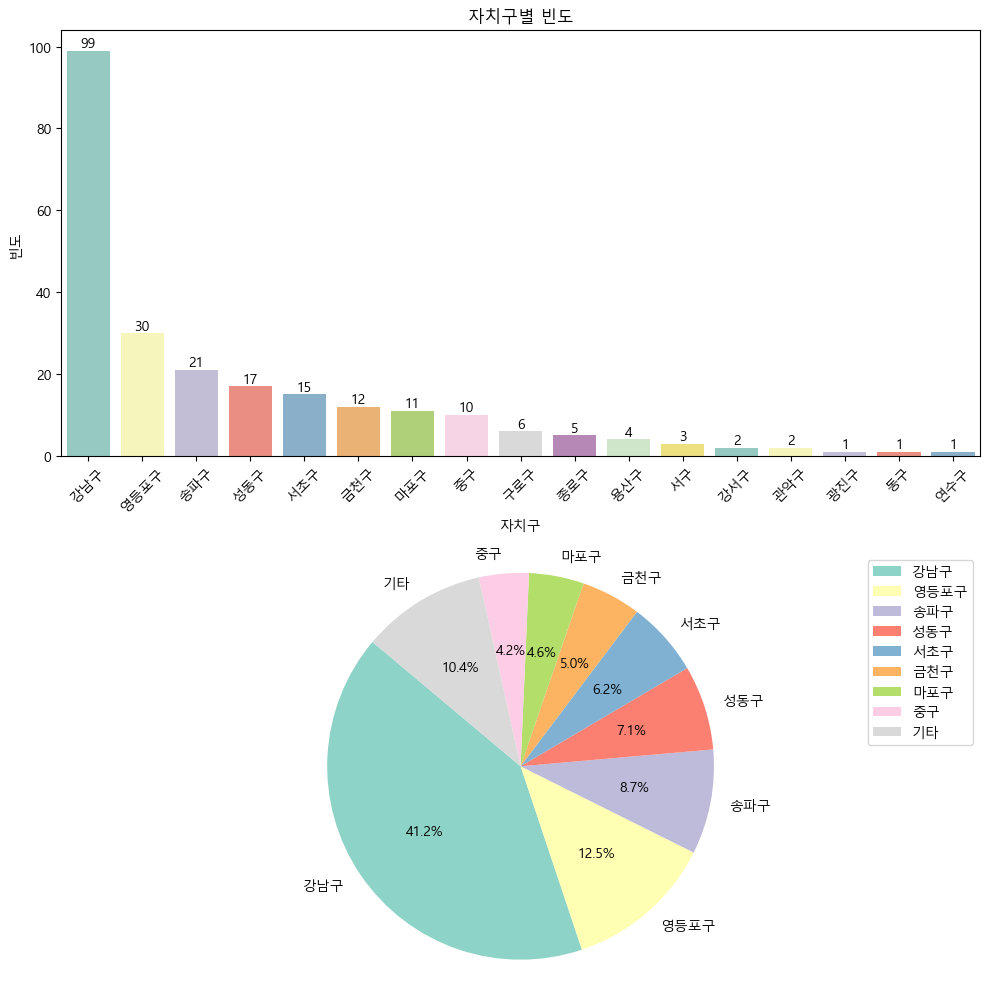

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

# 예제 데이터 생성 또는 데이터 로딩
# df = ...

# '구' 컬럼에서 단어 끝이 '구'로 끝나지 않는 인덱스 제외
filtered_df = df[df['district'].str.contains(r'구$') | df['district'].isna()]

# 바 그래프 색상 팔레트 설정
palette = 'Set3'

# 각 '구'별 빈도수 계산
district_counts = filtered_df['district'].value_counts()

# 빈도수를 기준으로 '구' 목록 정렬 (빈도가 높은 순으로)
sorted_districts = district_counts.index.tolist()

# 그래프 영역 설정
plt.figure(figsize=(10, 10))

# 첫 번째 서브플롯에 바플롯 그리기
plt.subplot(2, 1, 1)
ax1 = sns.countplot(data=filtered_df, x='district', order=sorted_districts, palette=palette)
plt.title('자치구별 빈도')
plt.xlabel('자치구')
plt.ylabel('빈도')
plt.xticks(rotation=45)

# 막대 위에 값 표시
for p in ax1.patches:
    ax1.annotate(f'{p.get_height():.0f}', (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha='center', va='center', fontsize=10, color='black', xytext=(0, 5),
                 textcoords='offset points')

# 두 번째 서브플롯에 파이 차트 그리기
plt.subplot(2, 1, 2)
district_counts = filtered_df['district'].value_counts()
make_etc = district_counts[district_counts >= 10].copy()
make_etc['기타'] = district_counts[district_counts < 10].sum()

# 색상 팔레트 재설정
colors = sns.color_palette(palette, len(make_etc))

plt.pie(make_etc, labels=make_etc.index, autopct='%1.1f%%', startangle=140, colors=colors)
plt.axis('equal')  # 원을 동그랗게 만듦
plt.legend()

plt.tight_layout()
plt.show()
